# Demo of endpoint variant_distribution

Documentation: http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.variant_distribution

This time, we are going to select all the individuals originating from the American and South Asian continents, who have two variants located on opposite chromosome copies of the hg19 reference assembly. We refer to these variants through an identifier assigned from dbSNP. 

Given this sample set, we wil ask for the distribution of the variant (target_variant) with id 'rs376342519' with respect to the gender and super_population attributes (distribute_by).

In [1]:
import json
param = {
    'distribute_by': ['gender', 'super_population'],
    'meta': {
        'super_population': ['AFR', 'SAS'],
        'assembly': 'hg19'
    },
    'variants': {
        'on_diff_chrom_copy': [{'id': 'rs367896724'}, {'id': 'rs555500075'}]
    },
    'target_variant': {'id': 'rs72670621'}
}
body = json.dumps(param)
print(body)

{"distribute_by": ["gender", "super_population"], "meta": {"super_population": ["AFR", "SAS"], "assembly": "hg19"}, "variants": {"on_diff_chrom_copy": [{"id": "rs367896724"}, {"id": "rs555500075"}]}, "target_variant": {"id": "rs72670621"}}


POST the endpoint \variant_distribution with the prepared JSON parameter and query parameters.

In [2]:
import requests

r = requests.post('http://geco.deib.polimi.it/popstudy/api/variant_distribution', json=param)
print(' response status code: {}'.format(r.status_code))
response_body = r.json()

response status code: 200


# Inspect response data:
It's a data cube with the numerosity of the individuals grouped on the free-dimensions: gender, dna_source and population (to be intended as country of origin)

In [6]:
import pandas as pd
from matplotlib import pyplot as plt
columns = response_body['columns']
rows = response_body['rows']
df = pd.DataFrame.from_records(rows, columns=columns)
df.fillna(value='', inplace=True)    # replaces Nones (== any value) with ''

df0 = df.pivot_table(df, ['SUPER_POPULATION', 'GENDER'])
df0 = df0[['POPULATION_SIZE', 'POSITIVE_DONORS', 'OCCURRENCE_OF_TARGET_VARIANT', 'FREQUENCY']]
df0

POPULATION_SIZE  POSITIVE_DONORS  \
SUPER_POPULATION GENDER                                     
                                     291               76   
                 female              143               42   
                 male                148               34   
AFR                                  177               66   
                 female               97               38   
                 male                 80               28   
SAS                                  114               10   
                 female               46                4   
                 male                 68                6   

                         OCCURRENCE_OF_TARGET_VARIANT  FREQUENCY  
SUPER_POPULATION GENDER                                           
                                                   86   0.147766  
                 female                            47   0.164336  
                 male                              39   0.131757  
AFR                                                76   0.214689  
                 female                            43   0.221649  
                 male                              33   0.206250  
SAS                                                10   0.043860  
                 female                             4   0.043478  
                 male                               6   0.044118

The selected popualtion counts of 291 donors, but only 76 of them show the target variant, more or less 1/4. Nevertheless, most of the positive donors have only 1 occurrence of such variant (i.e. it is rarely a heterozygous variant), so that's why the overall frequency is actually much less: 14,7%.

Let's see how the individuals are distributed inside the different continents:

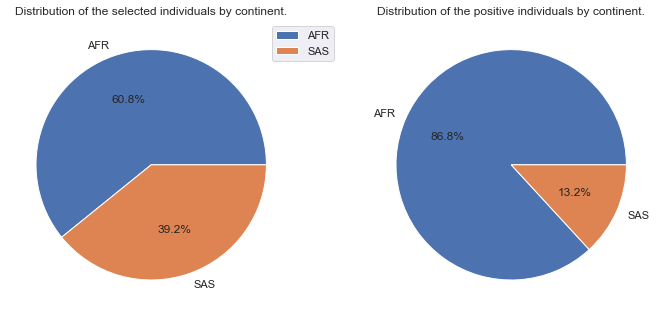

In [68]:
import seaborn as sns
# use Seaborn styles
sns.set()

df10 = df.drop(df.query('GENDER != "" | SUPER_POPULATION == ""').index)  # remove rows where gender is not empty or super_population is any
# we prepare two data frames, one containing the population_size, and the other one containing the positive donorsn.
df11 = df10.drop(['GENDER', 'OCCURRENCE_OF_TARGET_VARIANT', 'FREQUENCY', 'POSITIVE_DONORS'], inplace=False, axis=1) # remove unnecesary columns
df11 = df11.pivot_table(df11, index=['SUPER_POPULATION'])

df12 = df10.drop(['GENDER', 'OCCURRENCE_OF_TARGET_VARIANT', 'FREQUENCY', 'POPULATION_SIZE'], inplace=False, axis=1) # remove unnecesary columns
df12 = df12.pivot_table(df12, index=['SUPER_POPULATION'])


fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(df11, labels=df11.index.tolist(), autopct='%1.1f%%')
ax1.set_title('Distribution of the selected individuals by continent.')

ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
ax2.pie(df12, labels=df12.index.tolist(), autopct='%1.1f%%')
ax2.set_title('Distribution of the positive individuals by continent.')

ax1.legend(bbox_to_anchor=(.9, 1.0))    # place only one legend beacuse the index for the two data frames is the same
plt.show()


We notice that the criteria used for selecting the population - the presence of variants rs367896724 and rs555500075 on opposite chromatids - have a greater compatibility in the African population than in the Asian one.  60% vs 40%.

Also, the number of individuals resulting positive to the target varaint are far more in the African individuals. Let's compare the frequency of the variant by continent then:

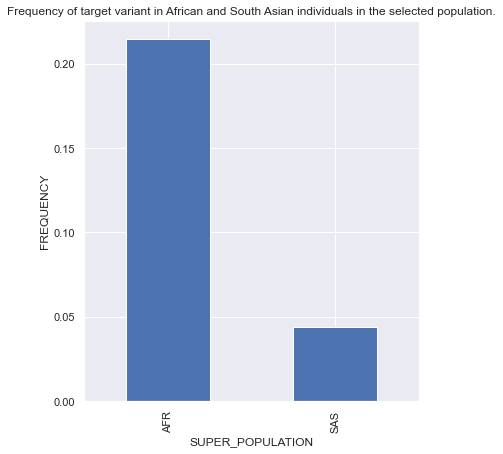

In [79]:
df2 = df.drop(df.query('GENDER != "" | SUPER_POPULATION == ""').index)
df2.drop(['POPULATION_SIZE', 'POSITIVE_DONORS', 'OCCURRENCE_OF_TARGET_VARIANT', 'GENDER'], inplace=True, axis=1)
df2.pivot_table(df2, index='SUPER_POPULATION').plot(
    kind='bar',
    figsize=(6, 7),
    legend=False
)
plt.title('Frequency of target variant in African and South Asian individuals in the selected population.')
plt.ylabel('FREQUENCY')
plt.show()

This shows a much larger adoption of the target variant rs376342519 in the African population: ~4 times more. Such increment doesn't seem to be correlated to the larger number of African individuals which corresponds to 60.8% of the total, i.e. just 1,55 times more the number of South Asian individuals.  

Notice that we could have expressed all the variant identifiers in this notebook also by their coordinates (chrom, start, reference and alternative alleles) obtaining the same results.